9/11/24

this code now does pairwise comparisons and has chatgpt provide an explanation, with company A or company B at the end of the explanation. then it gets the last token's log prob and outputs the explanation and top two log probs for each comparison.

currently:
25 a list, 25 non a list - chosen from stratified sampling
each company is compared to 20 other companies in the same industry, from the entire dataset

8/28 version:

the following code should do pairwise comparisons between industries.
we are going to compare each company with 10? random other companies in the same industry.
ex.
compare a to b, a to c, a to d, etc until a has 10 comparisons

every company will have a number between 0 and 10 depending on their record.

from there, we will see what percentage of group 10 are a list companies, etc.


In [1]:
import openai
# MODEL = 'gpt-4o-2024-08-06'
MODEL = 'gpt-4o-mini'
from api_keys import OPEN_AI_API_KEYS
key = OPEN_AI_API_KEYS[0]
client = openai.OpenAI(api_key=key)
openai.api_key = key

import numpy as np
import pandas as pd
import csv


In [2]:
def prepare_messages(prompts):
	messages = []
	for prompt in prompts:
		line = {"role": "user", "content": prompt}
		messages.append(line)
	return messages

def get_model_output_initial_sentences(prompts, client): 
    # Cycle through clients to avoid rate limiting
	completion = client.chat.completions.create(
		model = MODEL,
		messages = prepare_messages(prompts),
		temperature = 0
	)
	output = completion.choices[0].message.content
	return output

In [3]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4o-mini",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [4]:
prompts = [

    "Please act as an impartial judge and evaluate the quality ",
    "of the responses provided by two companies to the questions ",
    "displayed below. Your evaluation should consider factors ",
    "such as the specificity, clarity, completeness, and depth ",
    "of their responses. In addition, consider the amount of tangible",
    "action that is being taken based on the responses. ",
    #"The answer should have a neutral, unbiased tone without any negative connotations",
    #" or attempts to persuade. ",
    #"Choose the answer that avoids greenwashing tactics, such as vague ",
    #"or irrelevant claims and lack of proof of actions. ",
    "Avoid any position biases and ensure that the order in which the responses were presented ",
    "does not influence your decision. Do not allow the length of the responses ",
    "to influence your evaluation. Do not favor certain names of the companies.", 
    "Be as objective as possible. There are two questions, but some companies may ",
    "only respond to one or the other. Do not allow the lack of one response",
    "to influence your decision. Do not allow repetition to influence your decision. ",
    "Please do not provide any sort of explanation."
    # "Begin your evaluation by comparing the two responses and ",
    # "provide a short explanation. After providing your explanation, ",
    # "output your final verdict by strictly following this format: ",
    #"A if company A is better and B if company B is better.",
    #"Do not start with the word \"The\"."
    #"and \"C\" for a tie.",
    # "Provide a short explanation explaining why one company is better than the other. ",
    "Output your final verdict at the end by strictly following this format: ",
    "A if company A is better and B if company B is better.",
    # "Keep your explanation to 40 words."
    "Please do not provide any sort of explanation."
    "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain. ",
    "Question 2: Provide details of your emissions intensity target(s) and progress made against those targets. - Please explain. ",
    "[The Start of Company A’s Question 1 Response] {answer1a} [The End of Company A’s Response]",
    "[The Start of Company A’s Question 2 Response] {answer1b} [The End of Company A’s Response]",
    "[The Start of Company B’s Question 1 Response] {answer2a} [The End of Company B’s Response]",
    "[The Start of Company B’s Question 2 Response] {answer2b} [The End of Company B’s Response]",
    "Start your response after this sentence."

]

In [5]:
def get_log_prob(answer1a, answer1b, answer2a, answer2b, company_1, company_2):
    try:
        formatted_prompt = "".join(prompts).format(
            answer1a=answer1a, 
            answer1b=answer1b, 
            answer2a=answer2a, 
            answer2b=answer2b
        )
        # print("answer1a:", answer1a)
        # print("answer1b:", answer1b)
        # print("answer2a:", answer2a)
        # print("answer2b:", answer2b)
        # print(company_1)
        # print(company_2)
        # print("Formatted Prompt:", formatted_prompt) 
        API_RESPONSE = get_completion(
            [{"role": "user", "content": formatted_prompt.format(answer1a=answer1a, answer1b=answer1b, answer2a=answer2a, answer2b=answer2b)}],
            model="gpt-4o-mini",
            logprobs=True,
            top_logprobs=2,
        )

        generated_answer = API_RESPONSE.choices[0].message.content
        # top_two_logprobs = API_RESPONSE.choices[0].logprobs.content
        top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[-1].top_logprobs

        # accesses top two log probs of last token
        # top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs[-1]
        # else:
        #     print("API Response:", API_RESPONSE)
        #     raise ValueError("Unexpected API response structure")

        # print(type(top_two_logprobs))
        # print("type API_RESPONSE.choices[0] : ", (type(API_RESPONSE.choices)))
        # print("type(logprobs.content[0]) : ", type(API_RESPONSE.choices[0].logprobs.content))
        # print(top_two_logprobs)
        # Initialize list to store token probabilities
        token_probabilities = []
        for i, logprob in enumerate(top_two_logprobs, start=1):

            token = logprob.token
            probability = np.round(np.exp(logprob.logprob)*100,2)
            token_probabilities.append((token, probability))
            # print("token:", token, "probability:", probability)
       
            
        return generated_answer, token_probabilities
    except KeyError as e:
        print(f"KeyError: {e}")
        print("Variables: answer1a:", answer1a, "answer1b:", answer1b, "answer2a:", answer2a, "answer2b:", answer2b)
        return [],[]
    except Exception as e:
        print(f"An error occurred: {e}")
        return [],[]

In [6]:
# variables for each years' questions
a_2019 = "C4.1a_C12_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
b_2019 = "C4.1b_C13_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
a_2020 = "C4.1a_C15_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2020 = "C4.1b_C18_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2021 = "C4.1a_C16_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2021 = "C4.1b_C19_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2022 = "C4.1a_C27_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain target coverage and identify any exclusions"
b_2022 = "C4.1b_C30_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain target coverage and identify any exclusions"

new main code that compares each company to the same 20 companies.

In [12]:
import pandas as pd
import csv

# Read the main dataset and the list of 25 companies
input_file = 'merged_files/2022_merged_dataset.csv'
# companies_to_look_at = 'Part_1_Company_Testing/pairwise_testing_sample_set/Non_A_List_Sample_25.csv'
# companies_to_look_at = "Part_1_Company_Testing/147_147_Companies/new_stratified_sample_147_non_a_list_companies.csv"
companies_to_look_at = "a-list_data_files/2022_a_list.csv"
# start_index = 112


# 24 companies
comparison_set = [
    "Pandora A/S", "thyssenkrupp AG", "J Sainsbury Plc", "AMG Advanced Metallurgical Group NV", 
    "Sonaca", "Havas", "Norwegian Property ASA", "Phoenix Group Holdings", 
    "SGS Société Générale de Surveillance SA", "TDC NET A/S", "DUCRON CONSTRUCTION", 
    "Vistry Group plc", "LAMBERT SMITH HAMPTON", 
    "Nouvelle Societe Mineral Products Internation", "Recordati SpA", "SKF", 
    "Amadeus IT Group, S.A.", "Vitesco Technologies", "SSAB", 
    "Coloplast A/S", "Severn Trent", "Ernst & Young Global Ltd", 
    "Softcat", "WHISTL UK LTD"
]

# Load datasets
df = pd.read_csv(input_file)
a_df = pd.read_csv(companies_to_look_at)

# Extract columns
company_name_list = df.loc[:, "Organization"]
industry_list = df.loc[:, 'Primary industry']
a_response_list = df.loc[:, a_2022]  # Replace with your 'a_2022' variable
b_response_list = df.loc[:, b_2022]  # Replace with your 'b_2022' variable

# Extract the companies to compare (from the list of 25 companies)
companies_to_look_at_list = a_df["Company Name"].tolist()

# output_file = 'Part_1_Company_Testing/pairwise_testing_against_same_20/25_Non_A_List.csv'
output_file = "Part_1_Company_Testing/147_147_Companies_No_Explanation/147_A_List_Comparisons_Version1.csv"
fields = ["Company A", "Company B", "Industry", "Decision", "Token 1", "LogProb 1", "Token 2", "LogProb 2"]

# Write output to CSV
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    # Loop through the 147 companies
    for index, companyA in enumerate(companies_to_look_at_list):
    # for index, companyA in enumerate(companies_to_look_at_list[start_index:], start=start_index):

        
        # Check if the current company exists in the dataset
        if companyA in company_name_list.values:
            row = df[df["Organization"] == companyA].iloc[0]  # Get the row for the current company
            industry = row["Primary industry"]
            response1a = row[a_2022]
            response1b = row[b_2022]
            
            if pd.notna(industry) and industry != "" and isinstance(industry, str):
                # Compare against the fixed list of 20 companies
                filtered_df = df[df["Organization"].isin(comparison_set)]
                a_random_response_list = filtered_df.loc[:, a_2022]
                b_random_response_list = filtered_df.loc[:, b_2022]
                random_company_name_list = filtered_df.loc[:, "Organization"]

                # Loop through the 20 fixed companies
                for random_list_index in range(len(filtered_df)):
                    response2a = a_random_response_list.iloc[random_list_index]
                    response2b = b_random_response_list.iloc[random_list_index]
                    companyB = random_company_name_list.iloc[random_list_index]

                    # Call the function to get log probabilities and tokens
                    answer1, list_log_probs = get_log_prob(response1a, response1b, response2a, response2b, companyA, companyB)
                    
                    if list_log_probs:
                        # Write data to CSV
                        line = {
                            "Company A": companyA, 
                            "Company B": companyB, 
                            "Industry": industry, 
                            "Decision": answer1, 
                            "Token 1": list_log_probs[0][0], 
                            "LogProb 1": list_log_probs[0][1], 
                            "Token 2": list_log_probs[1][0],
                            "LogProb 2": list_log_probs[1][1]
                        }
                        writer.writerow(line)
                    else:
                        print(f"Insufficient log probabilities for comparison between {companyA} and {companyB}.")

print(f"LogProbs have been written to {output_file}")

LogProbs have been written to Part_1_Company_Testing/147_147_Companies_No_Explanation/147_A_List_Comparisons_Version1.csv


currently using this code!
this new code doesnt swap alternating A and B columns. it switches to a new company when it sees a new company in the row that has not been accounted for in the dict.

In [18]:
import pandas as pd

# File paths
input_file = "Part_1_Company_Testing/147_147_Companies/147_Non_A_List_Pairwise.csv"
output_file = "Part_1_Company_Testing/147_147_Companies/New_Averages_147_Non_A_List.csv"

# Read input CSV
df = pd.read_csv(input_file)

# Initialize tracking variables
log_prob_data = {}
current_company = None
total_score = 0.0
total_count = 0

# Iterate over each row
for index, row in df.iterrows():
    company_a = row['Company A']
    token_1 = row['Token 1'].strip()
    logprob_1 = row['LogProb 1']
    logprob_2 = row['LogProb 2']

    # Check for a new company
    if company_a != current_company:
        # Finalize the previous company's calculations
        if current_company is not None and total_count > 0:
            avg_log_prob = total_score / total_count
            log_prob_data[current_company] = avg_log_prob

        # Reset counters for the new company
        current_company = company_a
        total_score = 0.0
        total_count = 0

    # Add probabilities for both scenarios
    if token_1 == 'A':
        total_score += logprob_1
    else:  # Token 1 is 'B'
        total_score += logprob_2
    total_count += 1

# Finalize the last company's calculations
if current_company is not None and total_count > 0:
    avg_log_prob = total_score / total_count
    log_prob_data[current_company] = avg_log_prob

# Create a DataFrame from the results
log_prob_df = pd.DataFrame([
    {'Company': company, 'Average_Log_Probability': avg_log_prob}
    for company, avg_log_prob in log_prob_data.items()
])

# Save to CSV
log_prob_df.to_csv(output_file, index=False)

print("Average log probabilities have been calculated and saved.")

Average log probabilities have been calculated and saved.


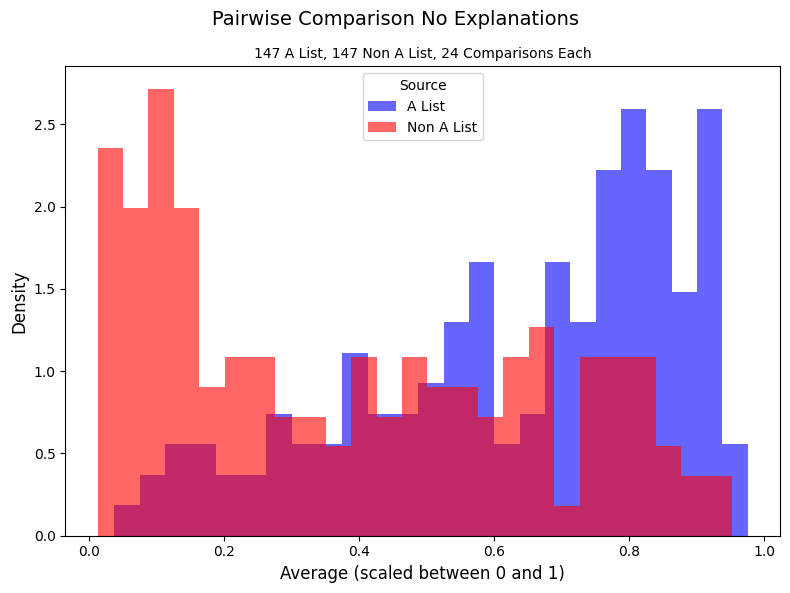

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for A-list and Non-A-list averages
a_list_file = "Part_1_Company_Testing/147_147_Companies_No_Explanation/Averages_147_A_List.csv"
non_a_list_file = "Part_1_Company_Testing/147_147_Companies_No_Explanation/Averages_147_Non_A_List.csv"

# Read the CSV files into DataFrames
a_list_df = pd.read_csv(a_list_file)
non_a_list_df = pd.read_csv(non_a_list_file)

# Scale down the 'Average_Log_Probability' column by dividing by 100
a_list_df['Scaled_Log_Probability'] = a_list_df['Average_Log_Probability'] / 100
non_a_list_df['Scaled_Log_Probability'] = non_a_list_df['Average_Log_Probability'] / 100

# Add a column to differentiate the datasets
a_list_df['Source'] = 'A List'
non_a_list_df['Source'] = 'Non A List'

# Combine the two datasets for easier plotting
combined_df = pd.concat([a_list_df, non_a_list_df])

# Plot the histogram
plt.figure(figsize=(8, 6))

# Create overlapping histograms with transparency
plt.hist(
    a_list_df['Scaled_Log_Probability'], bins=25, alpha=0.6, 
    label='A List', color='blue', density=True

)
plt.hist(
    non_a_list_df['Scaled_Log_Probability'], bins=25, alpha=0.6, 
    label='Non A List', color='red', density=True
)

# Add labels, title, and legend
# Add main title and smaller subtitle
plt.suptitle("Pairwise Comparison No Explanations", fontsize=14)
plt.title("147 A List, 147 Non A List, 24 Comparisons Each", fontsize=10)
plt.xlabel("Average (scaled between 0 and 1)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Source")

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()


the following graphs

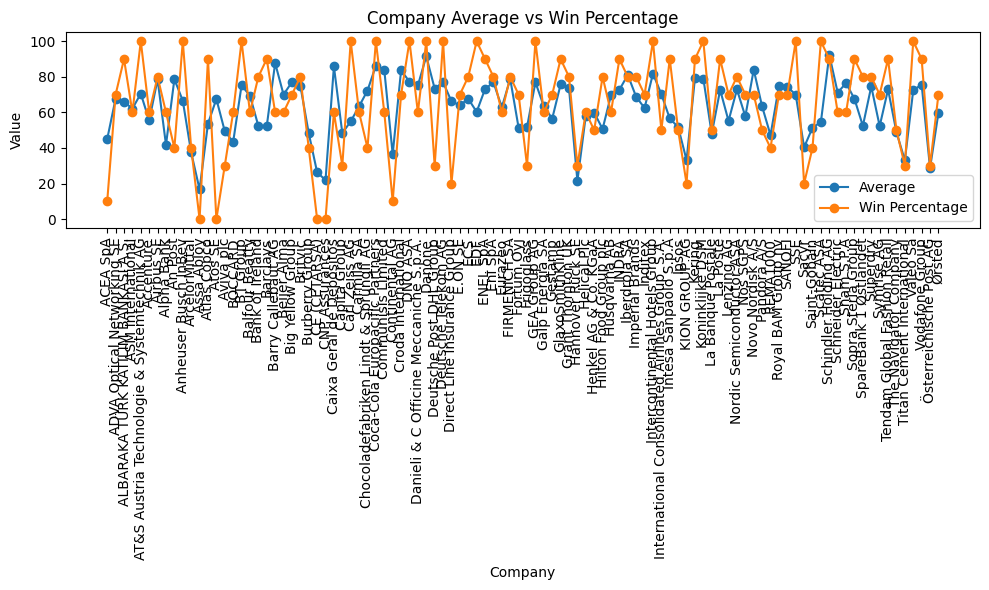

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
average_df = pd.read_csv('Part_1_Company_testing/Pairwise_Average_2022_100_Companies.csv')  
win_percentage_df = pd.read_csv('Part_1_Company_testing/100_Companies_Win_Percentage.csv')  
# Merge the two datasets on the 'Company' column
merged_df = pd.merge(average_df, win_percentage_df, on='Company')

# Sort the merged data by company name for easier viewing in the plot
merged_df.sort_values('Company', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the "Average" values
plt.plot(merged_df['Company'], merged_df['Average'], label='Average', marker='o')

# Plot the "Win Percentage" values
plt.plot(merged_df['Company'], merged_df['Win Percentage'], label='Win Percentage', marker='o')

# Add labels and title
plt.xlabel('Company')
plt.ylabel('Value')
plt.title('Company Average vs Win Percentage')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


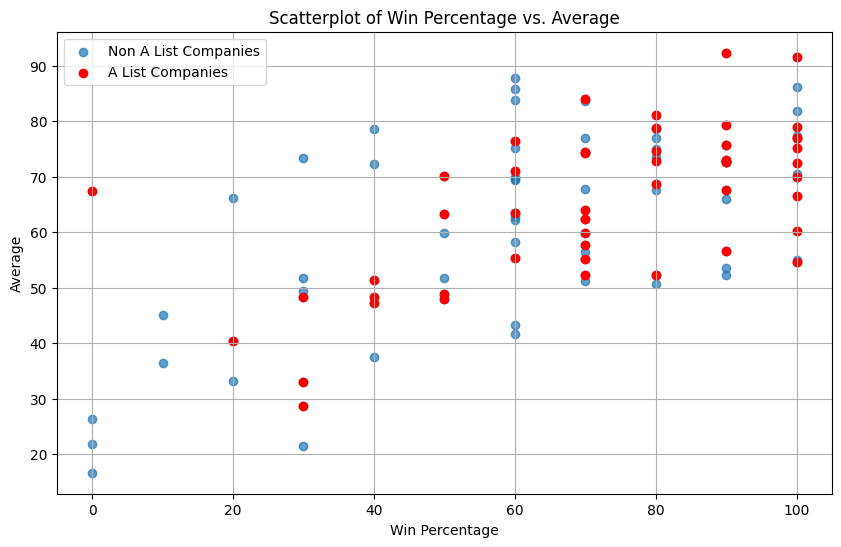

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
average_df = pd.read_csv('Part_1_Company_testing/Pairwise_Average_2022_100_Companies.csv')  
win_percentage_df = pd.read_csv('Part_1_Company_testing/100_Companies_Win_Percentage.csv')  
a_list_df = pd.read_csv('Part_1_Company_testing/50_A_List.csv')

# Merge the datasets on 'Company'
merged_df = pd.merge(average_df, win_percentage_df, on='Company')

# Create a list of companies from the A List
a_list_companies = a_list_df['Company'].tolist()

# Plot the scatterplot
plt.figure(figsize=(10, 6))

# Plot all companies
plt.scatter(merged_df['Win Percentage'], merged_df['Average'], alpha=0.7, label='Non A List Companies')

# Highlight A List companies in red
a_list_df = merged_df[merged_df['Company'].isin(a_list_companies)]
plt.scatter(a_list_df['Win Percentage'], a_list_df['Average'], color='red', label='A List Companies')

plt.title('Scatterplot of Win Percentage vs. Average')
plt.xlabel('Win Percentage')
plt.ylabel('Average')
plt.grid(True)
plt.legend()
plt.show()


split datafile into two seperate datafiles for a list and non a list

In [ ]:
import pandas as pd

# Load the datasets
# data_df = pd.read_csv('Part_1_Company_testing/Pairwise_Average_2022_100_Companies.csv')  
data_df = pd.read_csv('Part_1_Company_testing/100_Companies_Win_Percentage.csv') 
a_list_df = pd.read_csv('Part_1_Company_testing/50_A_List.csv')  # Replace '50_A_List.csv' with your file name

# Create a list of A List companies
a_list_companies = a_list_df['Company'].tolist()

# Filter the data into A List and Non A List
a_list_data = data_df[data_df['Company'].isin(a_list_companies)]
non_a_list_data = data_df[~data_df['Company'].isin(a_list_companies)]

# Save to CSV files
a_list_data.to_csv('Part_1_Company_testing/50_A_List_Company_Score_With_Explanation.csv', index=False)
non_a_list_data.to_csv('Part_1_Company_testing/50_Non_A_List_Company_Score_With_Explanation.csv', index=False)

print("Data successfully split into two files: 'A_List_Companies.csv' and 'Non_A_List_Companies.csv'.")


Data successfully split into two files: 'A_List_Companies.csv' and 'Non_A_List_Companies.csv'.


the following takes in one file with all 100 companies and the list of 50 a list companies, then graphs the histogram seperating the two.

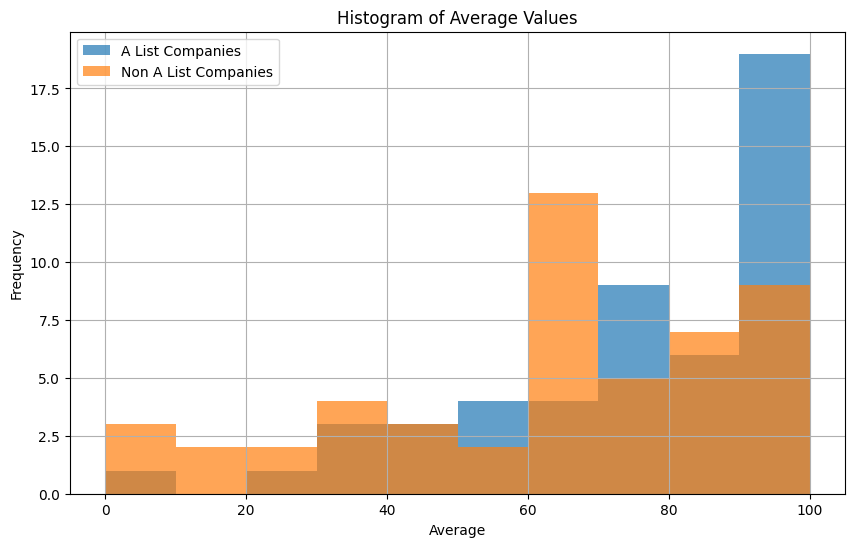

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
# data_df = pd.read_csv('Part_1_Company_testing/Pairwise_Average_2022_100_Companies.csv')  
data_df = pd.read_csv('Part_1_Company_testing/100_Companies_Win_Percentage.csv') 

a_list_df = pd.read_csv('Part_1_Company_testing/50_A_List.csv')  # Replace '50_A_List.csv' with your file name

# Create a list of A List companies
a_list_companies = a_list_df['Company'].tolist()

# Create a column to classify companies as A List or not
data_df['Category'] = data_df['Company'].apply(lambda x: 'A List' if x in a_list_companies else 'Non A List')

# Plot the histogram
plt.figure(figsize=(10, 6))

# Plot histogram for A List companies
plt.hist(data_df[data_df['Category'] == 'A List']['Win Percentage'], bins=10, alpha=0.7, label='A List Companies')

# Plot histogram for Non A List companies
plt.hist(data_df[data_df['Category'] == 'Non A List']['Win Percentage'], bins=10, alpha=0.7, label='Non A List Companies')

plt.title('Histogram of Average Values')
plt.xlabel('Average')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

the following code takes in pairwise full file and calculates average log prob for token A (first company wins)
- accounts for if companies have different number of rows
- edited to account for when a company is run twice, with company order switched

In [ ]:
# Load the CSV file into a DataFrame
# df = pd.read_csv('pairwise_files/two_runs_per_pair/2018_Non_A_List.csv')
# df = pd.read_csv('Part_1_Company_Testing/2022_100_Companies_Pairwise_With_Actual_Answer.csv')
df = pd.read_csv('Part_1_Company_Testing/pairwise_testing_sample_set/25_Non_A_List_Explanations.csv')
fields = ["Company", "Average"]

# output_file = "pairwise_files/two_runs_per_pair/2018_Non_A_List_Average.csv"
output_file = "Part_1_Company_Testing/pairwise_testing_sample_set/25_Non_A_List_Averages.csv"

company_A_name_list = df.loc[:,"Company A"]
company_B_name_list = df.loc[:,"Company B"]
token_1 = df.loc[:,"Token 1"]
log_value_1 = df.loc[:,"LogProb 1"]
token_2 = df.loc[:,"Token 2"]
log_value_2 = df.loc[:,"LogProb 2"]

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    #check to see if next item is same company
    index = 0

    while(index < len(df)):
        num_to_divide = 1
        first_company = company_A_name_list.iloc[index]
        # print("first company: ", first_company)
        if(token_1.iloc[index] == 'A'):
            log = log_value_1.iloc[index]
        else:
            log = log_value_2.iloc[index]
        while (index+1 < len(df)):
            next_A_company = company_A_name_list.iloc[index+1]
            next_B_company = company_B_name_list.iloc[index+1]
            # print("next_A_company", next_A_company)
            # print("next_B_company", next_B_company)
            if (first_company == next_A_company):
                # check if token 1 or token 2 is A, for current index and next index
                if(token_1.iloc[index+1] == 'A'):
                    log += log_value_1.iloc[index+1]
                else:
                    log += log_value_2.iloc[index+1]
                num_to_divide += 1
                # print("current log value in first if: ", log)
                index += 1
            elif(first_company == next_B_company):
                if(token_1.iloc[index+1] == 'B'):
                    log += log_value_1.iloc[index+1]
                else:
                    log += log_value_2.iloc[index+1]
                num_to_divide += 1
                # print("current log value in second if: ", log)
                index += 1
            else:
                break
        log /= num_to_divide
        line = {"Company":first_company,"Average":log}
        writer.writerow(line)
        index += 1

    csvfile.close()
print("successfully written to: ", output_file)

the following takes in the file with all the log probs and splits into 2 files - A List vs non A List

In [ ]:
# Load the CSV file into a DataFrame
input_df = pd.read_csv('merged_files/2019_merged_dataset.csv')

reference_df = pd.read_csv('a-list_data_files/2019_a_list.csv')

# Create a set of companies from the reference file for fast lookup
reference_companies = set(reference_df['Company Name'])

# Split the input DataFrame into two based on whether 'Company A' is in the reference file
in_reference = input_df[input_df['Organization'].isin(reference_companies)]
not_in_reference = input_df[~input_df['Organization'].isin(reference_companies)]

# Save the resulting DataFrames to new CSV files
in_reference.to_csv('2019_on_A_List.csv', index=False)
not_in_reference.to_csv('2019_not_on_A_List.csv', index=False)

# Print the resulting DataFrames
print("Companies in reference file:")
print(in_reference)
print("\nCompanies not in reference file:")
print(not_in_reference)

Companies in reference file:
                Organization  \
5               ACCIONA S.A.   
11               AENA SME SA   
36                 Accenture   
43               Air Liquide   
70               AstraZeneca   
..                       ...   
721         Vattenfall Group   
723             Veidekke ASA   
770          thyssenkrupp AG   
772  Österreichische Post AG   
773                   Ørsted   

                                               Country  \
5                                                Spain   
11                                               Spain   
36                                             Ireland   
43                                              France   
70   United Kingdom of Great Britain and Northern I...   
..                                                 ...   
721                                             Sweden   
723                                             Norway   
770                                            Germany   
772   

the following takes in average csv files and creates a histogram

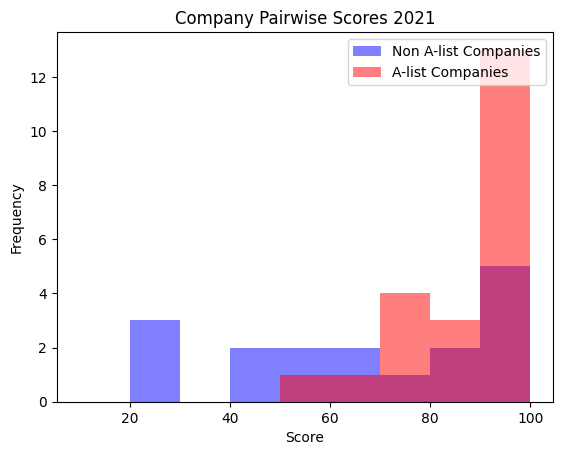

In [ ]:
import matplotlib.pyplot as plt 
year = "2021"

df_a_list = pd.read_csv("Part_1_Company_Testing/pairwise_testing_sample_set/25_A_List_Averages.csv")
df_non_a_list = pd.read_csv("Part_1_Company_Testing/pairwise_testing_sample_set/25_Non_A_List_Averages.csv")
# df_a_list = pd.read_csv("pairwise_files/two_runs_per_pair/" + year + "_A_List_Average.csv")
# # df_a_list["Average"].hist(bins=[10,20,30,40,50,60,70,80,90,100])

# df_non_a_list = pd.read_csv("pairwise_files/two_runs_per_pair/" + year + "_Non_A_List_Average.csv")
# df_non_a_list["Average"].hist(bins=[10,20,30,40,50,60,70,80,90,100])


# Plot histograms in the same figure
plt.hist(df_non_a_list["Weighted_Average"], bins=[10,20,30,40,50,60,70,80,90,100], 
         alpha=0.5, label='Non A-list Companies', color='blue')
plt.hist(df_a_list["Weighted_Average"], bins=[10,20,30,40,50,60,70,80,90,100], 
         alpha=0.5, label='A-list Companies', color='red')


# plt.hist(df_non_a_list["Average"], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='Non A-list Companies', color='skyblue')
# plt.hist(df_a_list["Average"], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='A-list Companies', color='red')

# df_a_list['Average'].hist(color='skyblue')
# df_non_a_list["Average"].hist(color='red')

plt.xlabel('Score')
plt.ylabel('Frequency')
hist_title = "Company Pairwise Scores " + year
plt.title(hist_title)
plt.legend(loc='upper right')

png_name = "pairwise_files/two_runs_per_pair/histograms/" + year + "_Combined_Scores.png"
plt.savefig(png_name)

# # Add labels and title
# plt.xlabel('Average Score')
# plt.ylabel('Frequency')
# hist_title = "Non A List Company Scores " + year
# plt.title(hist_title)

# Calculate statistics
# mean_value = df['Average'].mean()
# median_value = df['Average'].median()
# mode_value = df['Average'].mode()[0]
# std_dev = df['Average'].std()
# print(f"Mean: {mean_value}")
# print(f"Median: {median_value}")
# print(f"Mode: {mode_value}")
# print(f"Standard deviation: {std_dev}")



In [ ]:
import matplotlib.pyplot as plt 
year = "2018"

df = pd.read_csv("pairwise_files/" + year + "_Non_A_List_Average.csv")
# df = pd.read_csv("pairwise_files/" + year + "_A_List_Average.csv")
df["Average"].hist(bins=[10,20,30,40,50,60,70,80,90,100])

# Define a threshold
threshold_value = 50

# Count how many values are above the threshold
above_threshold_count = len(df[df['Average'] > threshold_value])

# Count how many values are below the threshold
below_threshold_count = len(df[df['Average'] <= threshold_value])

# Print the counts
print(f"Number of values above the threshold ({threshold_value}): {above_threshold_count}")
print(f"Number of values below or equal to the threshold ({threshold_value}): {below_threshold_count}")

# Plot histogram
plt.hist(df['Average'], bins=[10,20,30,40,50,60,70,80,90,100], edgecolor='black', alpha=0.7)

# Add a threshold line
plt.axvline(threshold_value, color='purple', linestyle='dotted', linewidth=1)

# Add annotations
plt.text(threshold_value + 0.1, max(plt.ylim()) * 0.9, f'Threshold: {threshold_value}', color='purple')

# Highlight data points above the threshold
above_threshold = df[df['Average'] > threshold_value]
plt.hist(above_threshold['Average'], bins=[10,20,30,40,50,60,70,80,90,100], edgecolor='black', alpha=0.5, color='orange')

# Set titles and labels
hist_title = "Non A List Company Scores w Threshold " + year
plt.title(hist_title)
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [ ]:
def test_basic_request():
    try:
        response = get_completion(
            messages=[{"role": "user", "content": "What is the weather like today?"}],
            model="gpt-4o-mini",
            logprobs=True
        )
        
        # Print the response for debugging
        print("Basic Test API Response:", response)
        
        return response
    
    except Exception as e:
        print(f"An error occurred during the basic request: {e}")
        return {}

# Call the test function
test_basic_request()

API Response: ChatCompletion(id='chatcmpl-A1RycXCsvhfoFAOHYKNYcxsm1SyH0', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token="I'm", bytes=[73, 39, 109], logprob=-0.3133254, top_logprobs=[]), ChatCompletionTokenLogprob(token=' unable', bytes=[32, 117, 110, 97, 98, 108, 101], logprob=-0.3882489, top_logprobs=[]), ChatCompletionTokenLogprob(token=' to', bytes=[32, 116, 111], logprob=0.0, top_logprobs=[]), ChatCompletionTokenLogprob(token=' provide', bytes=[32, 112, 114, 111, 118, 105, 100, 101], logprob=-0.01270694, top_logprobs=[]), ChatCompletionTokenLogprob(token=' real', bytes=[32, 114, 101, 97, 108], logprob=-0.0011427187, top_logprobs=[]), ChatCompletionTokenLogprob(token='-time', bytes=[45, 116, 105, 109, 101], logprob=0.0, top_logprobs=[]), ChatCompletionTokenLogprob(token=' weather', bytes=[32, 119, 101, 97, 116, 104, 101, 114], logprob=-0.23271073, top_logprobs=[]), ChatCompletionTokenLogprob(token=' updates', bytes=[

ChatCompletion(id='chatcmpl-A1RycXCsvhfoFAOHYKNYcxsm1SyH0', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token="I'm", bytes=[73, 39, 109], logprob=-0.3133254, top_logprobs=[]), ChatCompletionTokenLogprob(token=' unable', bytes=[32, 117, 110, 97, 98, 108, 101], logprob=-0.3882489, top_logprobs=[]), ChatCompletionTokenLogprob(token=' to', bytes=[32, 116, 111], logprob=0.0, top_logprobs=[]), ChatCompletionTokenLogprob(token=' provide', bytes=[32, 112, 114, 111, 118, 105, 100, 101], logprob=-0.01270694, top_logprobs=[]), ChatCompletionTokenLogprob(token=' real', bytes=[32, 114, 101, 97, 108], logprob=-0.0011427187, top_logprobs=[]), ChatCompletionTokenLogprob(token='-time', bytes=[45, 116, 105, 109, 101], logprob=0.0, top_logprobs=[]), ChatCompletionTokenLogprob(token=' weather', bytes=[32, 119, 101, 97, 116, 104, 101, 114], logprob=-0.23271073, top_logprobs=[]), ChatCompletionTokenLogprob(token=' updates', bytes=[32, 117, 112, 